## SDXL-v1.0 classic fine tuning (decoupled training job)
> aka native text2image training for whole model
* This is an experiment for fine tune SD-XL-v1.0 with Kohya-ss unpublished sd-scripts.
* Multi-gpu training example, training used seperated SageMaker training job
* Use [extending a pre-built container](https://docs.aws.amazon.com/sagemaker/latest/dg/prebuilt-containers-extend.html) method to build a docker image for training job
* ml.t3.medium notebook instance is good enough to run codes, configure storage with 100GB+, because we need to build large docker images for training job
* We used ml.p4d.24xlarge(8*A100 GPU) for SageMaker training job, as sdxl full model fine tuning required more gpu mem

## 1. Prepare training dataset

In [ ]:
# If you don't want to use kohya's tools to process training data, you can skip below steps 

!git clone https://github.com/kohya-ss/sd-scripts
%cd sd-scripts/
!pip install -U -r requirements.txt

In [2]:
TRAIN_DATA_DIR = "./images"
!mkdir -p $TRAIN_DATA_DIR

In [3]:
!wget -q https://huggingface.co/datasets/Linaqruf/locon-dataset/resolve/main/hitokomoru_locon_dataset.zip

In [4]:
import os
import shutil
import zipfile

zip_file = 'hitokomoru_locon_dataset.zip'
target_dir = TRAIN_DATA_DIR
temp_dir = target_dir+'/temp'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

bottom_dir = None
for root, dirs, files in os.walk(temp_dir):
    if not dirs:
        if bottom_dir is None:
            bottom_dir = root
        elif len(root.split(os.sep)) > len(bottom_dir.split(os.sep)):
            bottom_dir = root
        
for root, dirs, files in os.walk(bottom_dir):
    for file in files:
        if not file.endswith('.npz'):
            source_file = os.path.join(root, file)
            target_file = os.path.join(target_dir, file)
            shutil.copy(source_file, target_file)
    
shutil.rmtree(temp_dir)
os.remove('./hitokomoru_locon_dataset.zip')

In [ ]:
!python ./finetune/merge_captions_to_metadata.py --full_path $TRAIN_DATA_DIR $TRAIN_DATA_DIR/meta_cap.json

In [ ]:
!python ./finetune/merge_dd_tags_to_metadata.py --full_path $TRAIN_DATA_DIR --in_json $TRAIN_DATA_DIR/meta_cap.json $TRAIN_DATA_DIR/meta_cap_dd.json

In [ ]:
!python ./finetune/clean_captions_and_tags.py $TRAIN_DATA_DIR/meta_cap_dd.json $TRAIN_DATA_DIR/meta_clean.json

In [8]:
# Modify directories of metadata json-file for adapting sagemaker training job

import json

with open('./images/meta_clean.json', 'r') as f:
    data = json.load(f)
    
for key in list(data.keys()):
    if key.startswith('images/'):
        value = data[key]
        del data[key]
        new_key = key.replace('images/', '/opt/ml/input/data/images/')
        data[new_key] = value    
    
with open('./images/meta_clean.json', 'w') as f:
    json.dump(data, f)

## 2. Prepare Dockerfile and configurations for docker image building  

In [ ]:
%%writefile ./images/dataset.toml
[general]
enable_bucket = true
shuffle_caption = true
keep_tokens = 0
# color_aug = true

# Classic fine tuning based datasets
[[datasets]]
resolution = 1024
min_bucket_reso = 640
max_bucket_reso = 1536
bucket_reso_steps = 32
batch_size = 4

  [[datasets.subsets]]
  metadata_file = '/opt/ml/input/data/images/meta_clean.json'

In [ ]:
%%writefile ./images/sample_prompts.txt
# prompt 1
1girl, solo, looking at viewer, smile, short hair, bangs, hair ornament, closed mouth, purple eyes, upper body, braid, white hair, japanese clothes, wings, hair flower, kimono, hair over one eye, from side, looking to the side, kanzashi, chrysanthemum, simple background --n ugly, deformed, disfigured --w 832 --h 1216 --d 3129467234 --l 7.5 --s 20

# # prompt 2
1girl, solo, looking at viewer, smile, short hair, bangs, hair ornament, closed mouth, purple eyes, upper body, braid, white hair, japanese clothes, wings, hair flower, kimono, hair over one eye, from side, looking to the side, kanzashi, chrysanthemum, simple background --n ugly, deformed, disfigured --w 832 --h 1216 --d 3129467235 --l 7.5 --s 20


In [ ]:
%%writefile Dockerfile
FROM 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:2.0.0-gpu-py310-cu118-ubuntu20.04-sagemaker

ENV PATH="/opt/ml/code:${PATH}"
ENV SAGEMAKER_SUBMIT_DIRECTORY /opt/ml/code
ENV DEBIAN_FRONTEND noninteractive

RUN git clone -b sdxl https://github.com/kohya-ss/sd-scripts /opt/ml/code

WORKDIR /opt/ml/code

RUN mv sdxl_train.py sdxl_train && \
    sed -i 's/tensorboard==2.10.1/tensorboard==2.11.0/g; s/diffusers\[torch\]==0.18.2/diffusers\[torch\]==0.19.3/g;' requirements.txt && \
    sed -i '/opencv/d' requirements.txt && \
    sed -i 's/-e \./\./g' requirements.txt && \
    pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 --index-url https://download.pytorch.org/whl/cu118 --no-cache-dir && \
    pip install -U -r requirements.txt && \
    pip install xformers==0.0.20 wandb prodigyopt bitsandbytes==0.41.1

# RUN mkdir -p images/

# COPY ./images/* ./images/

WORKDIR /

ENV SAGEMAKER_PROGRAM accelerate.commands.launch --multi_gpu sdxl_train

## 3. Change default docker-root-dir of SageMaker notebook
> Default docker-root-dir of SageMaker notebook has limited space, which is not big enough for building large images

In [ ]:
!sudo service docker stop
!mkdir -p ~/SageMaker/docker-root
!sudo mv /var/lib/docker ~/SageMaker/docker-root
!sudo ln -s ~/SageMaker/docker-root/docker /var/lib/docker
!sudo service docker start

## 4. Build docker image and push to ECR

In [ ]:
%%sh

# Specify an algorithm name
algorithm_name=sd-classic-finetuning-job

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"
base_image_repo="763104351884.dkr.ecr.${region}.amazonaws.com"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1
if [ $? -ne 0 ]
then
aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly

aws ecr get-login-password --region ${region}|docker login --username AWS --password-stdin ${fullname}
aws ecr get-login-password --region ${region}|docker login --username AWS --password-stdin ${base_image_repo}

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

## 5. Train models with SageMaker training job

In [14]:
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
account_id = boto3.client('sts').get_caller_identity().get('Account')
region_name = boto3.session.Session().region_name
images_s3uri = 's3://{0}/train-dataset/images/'.format(bucket)

In [ ]:
# Copy training dataset to S3 bucket

!aws s3 cp images $images_s3uri --recursive

In [ ]:
import json
def json_encode_hyperparameters(hyperparameters):
    for (k, v) in hyperparameters.items():
        print(k, v)
    return {k: json.dumps(v) for (k, v) in hyperparameters.items()}

docker_image_uri = '{0}.dkr.ecr.{1}.amazonaws.com/sd-classic-finetuning-job'.format(account_id, region_name)
instance_type = 'ml.p4d.24xlarge'

base_model_name="stabilityai/stable-diffusion-xl-base-1.0"
output_dir="/opt/ml/model/"

hyperparameters = {
                    'pretrained_model_name_or_path': base_model_name,
                    'output_dir': output_dir,
                    'output_name': 'classic_finetune_hitokomoru_sdxl',
                    'dataset_config': '/opt/ml/input/data/images/dataset.toml',
                    'learning_rate': 1e-5,
                    'max_train_steps': 3000,
                    'max_token_length': 225,
                    'save_every_n_steps': 500,
                    'no_half_vae': '',
                    'xformers': '',
                    'optimizer_type': 'AdamW8bit',
                    'gradient_checkpointing': '',
                    'mixed_precision': 'bf16',
                    'full_bf16': '',
                    'min_snr_gamma': 5,
                    'cache_latents_to_disk': '',
                    'sample_every_n_steps': 500,
                    'sample_prompts': '/opt/ml/input/data/images/sample_prompts.txt',
                    'sample_sampler': 'euler_a',
                    'logging_dir': '/opt/ml/code/logs',
                    'log_with': 'all',
                    'log_tracker_name': 'classic_finetune_hitokomoru_sdxl_p4d',
                    'wandb_api_key': '4e2bdbd466cc74489f306a9da849e4ca13207708',
}

hyperparameters = json_encode_hyperparameters(hyperparameters)

In [ ]:
from sagemaker.estimator import Estimator

inputs = {
    'images': images_s3uri
}

estimator = Estimator(
    role = role,
    instance_count=1,
    instance_type = instance_type,
    image_uri = docker_image_uri,
    hyperparameters = hyperparameters
)
estimator.fit(inputs)

In [ ]:
model_data = estimator.model_data
print("Model artifact saved at:\n", model_data)

## 6. Deploy a model to SageMaker's inference endpoint for testing

In [ ]:
!mkdir outputs
!aws s3 cp $model_data ./outputs
!tar -zvxf ./outputs/model.tar.gz -C ./outputs
!rm ./outputs/model.tar.gz

In [ ]:
!pip install natsort

In [ ]:
from natsort import natsorted
from glob import glob
import os
WEIGHTS_DIR = natsorted(glob("./outputs" + os.sep + "*"))[0]
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}") 

In [ ]:
!mkdir -p $WEIGHTS_DIR/code

In [ ]:
%%writefile $WEIGHTS_DIR/code/requirements.txt
diffusers>=0.19.3
invisible_watermark
safetensors

In [ ]:
%%writefile $WEIGHTS_DIR/code/inference.py
# Inference code example for sdxl-v1.0

import base64
import torch
import boto3
import os
from botocore.exceptions import ClientError
from io import BytesIO
from diffusers import DiffusionPipeline, EulerAncestralDiscreteScheduler


def model_fn(model_dir):
    scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")
    base_pipe = DiffusionPipeline.from_pretrained(
        model_dir,
        scheduler=scheduler,
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
        cache_dir="/tmp/",
    ).to("cuda")
    return base_pipe


def encode_image(image):
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    encoded_image_response = base64.b64encode(buffered.getvalue()).decode()
    return encoded_image_response


def predict_fn(data, base_pipe):
    generator = torch.Generator(device="cuda")
    use_refiner = data.pop("refiner", "")
    high_noise_frac = data.pop("high_noise_frac", 0.8)
    prompt = data.pop("prompt", "")
    negative_prompt = data.pop("negative_prompt", "")
    height = data.pop("height", 1024)
    width = data.pop("width", 1024)
    num_inference_steps = data.pop("num_inference_steps", 20)
    guidance_scale = data.pop("guidance_scale", 7)
    num_images_per_prompt = data.pop("num_images_per_prompt", 2)
    seed = data.pop("seed", "")

    seeds = []
    encoded_images = []

    if seed:
        seeds = [seed + i for i in range(num_images_per_prompt)]
    else:
        seeds = [generator.seed() for _ in range(num_images_per_prompt)]

    for current_seed in seeds:
        generator.manual_seed(current_seed)
        base_pipe = base_pipe
            
        if use_refiner == "enable":
            notification = "SDXL refiner model is enabled!"
            
            refiner_model = "stabilityai/stable-diffusion-xl-refiner-1.0"
            refiner_pipe = DiffusionPipeline.from_pretrained(
                refiner_model,
                text_encoder_2=base_pipe.text_encoder_2,
                vae=base_pipe.vae,
                torch_dtype=torch.float16,
                use_safetensors=True,
                variant="fp16",
                cache_dir="/tmp/",
            ).to("cuda")    
            generated_images = base_pipe(
                prompt=prompt,
                negative_prompt=negative_prompt,
                height=height,
                width=width,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                denoising_end=high_noise_frac,
                generator=generator,
                output_type="latent",
            ).images
            generated_images = refiner_pipe(
                prompt=prompt,
                num_inference_steps=num_inference_steps,
                denoising_start=high_noise_frac,
                image=generated_images,
            ).images[0]
        else:
            notification = "SDXL refiner model is disabled!"
            
            generated_images = base_pipe(
                prompt=prompt,
                negative_prompt=negative_prompt,
                height=height,
                width=width,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=generator
            ).images[0]

        encoded_image_rt = encode_image(generated_images)
        encoded_images.append(encoded_image_rt)

    return {"notification": notification, "generated_images": encoded_images, "seeds": seeds}

In [ ]:
!tar --use-compress-program=pigz -pcvf $WEIGHTS_DIR/model.tar.gz -C $WEIGHTS_DIR/ .

In [ ]:
from sagemaker.s3 import S3Uploader
s3_model_uri=S3Uploader.upload(local_path=f"{WEIGHTS_DIR}/model.tar.gz", desired_s3_uri=f"s3://{sagemaker_session.default_bucket()}/model/sdxl-classic-finetune")

In [ ]:
from sagemaker.huggingface.model import HuggingFaceModel

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=s3_model_uri,      # path to your model and script
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version="4.28.1",  # transformers version used
   pytorch_version="2.0.0",       # pytorch version used
   py_version='py310',            # python version used
)

# deploy the endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type="ml.g5.2xlarge"
    )

In [32]:
from PIL import Image
from io import BytesIO
import base64
import datetime

# helper decoder
def decode_base64_image(image_string):
    base64_image = base64.b64decode(image_string)
    buffer = BytesIO(base64_image)
    return Image.open(buffer)


Notification: SDXL refiner model is enabled!



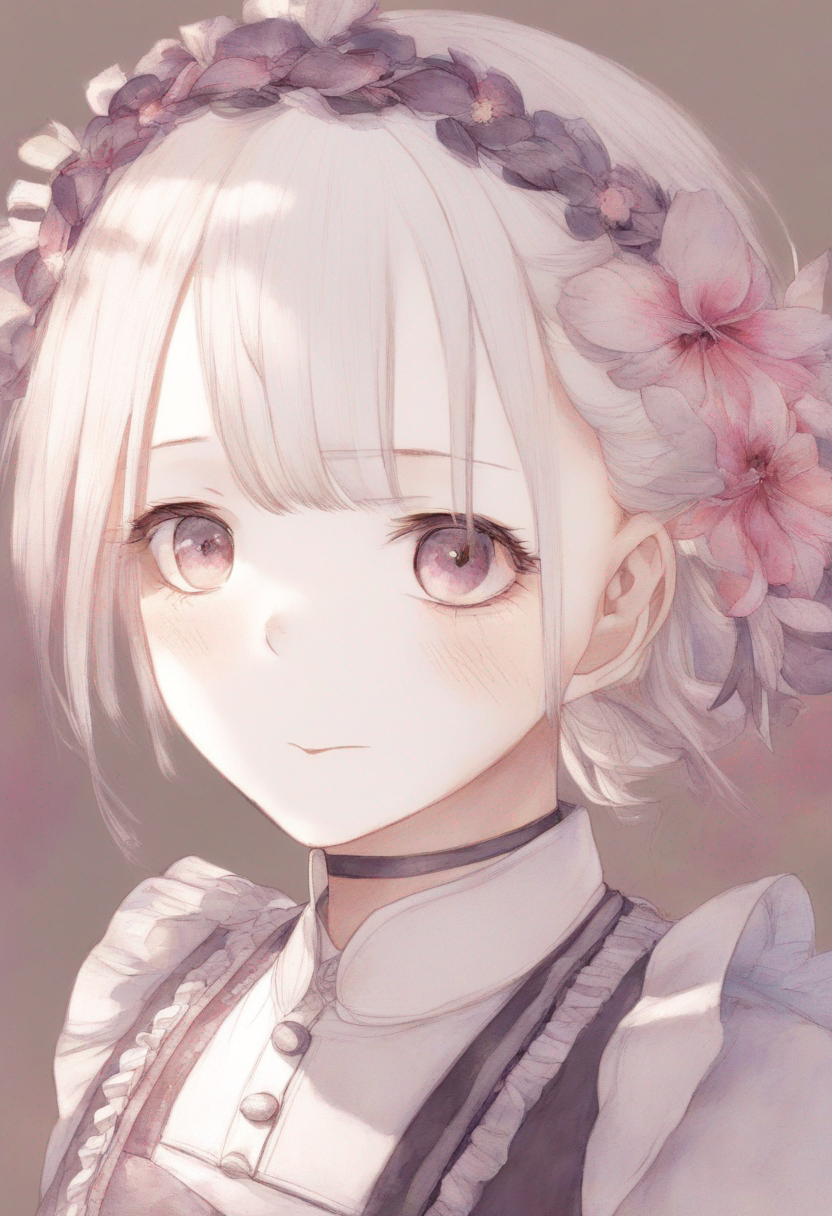

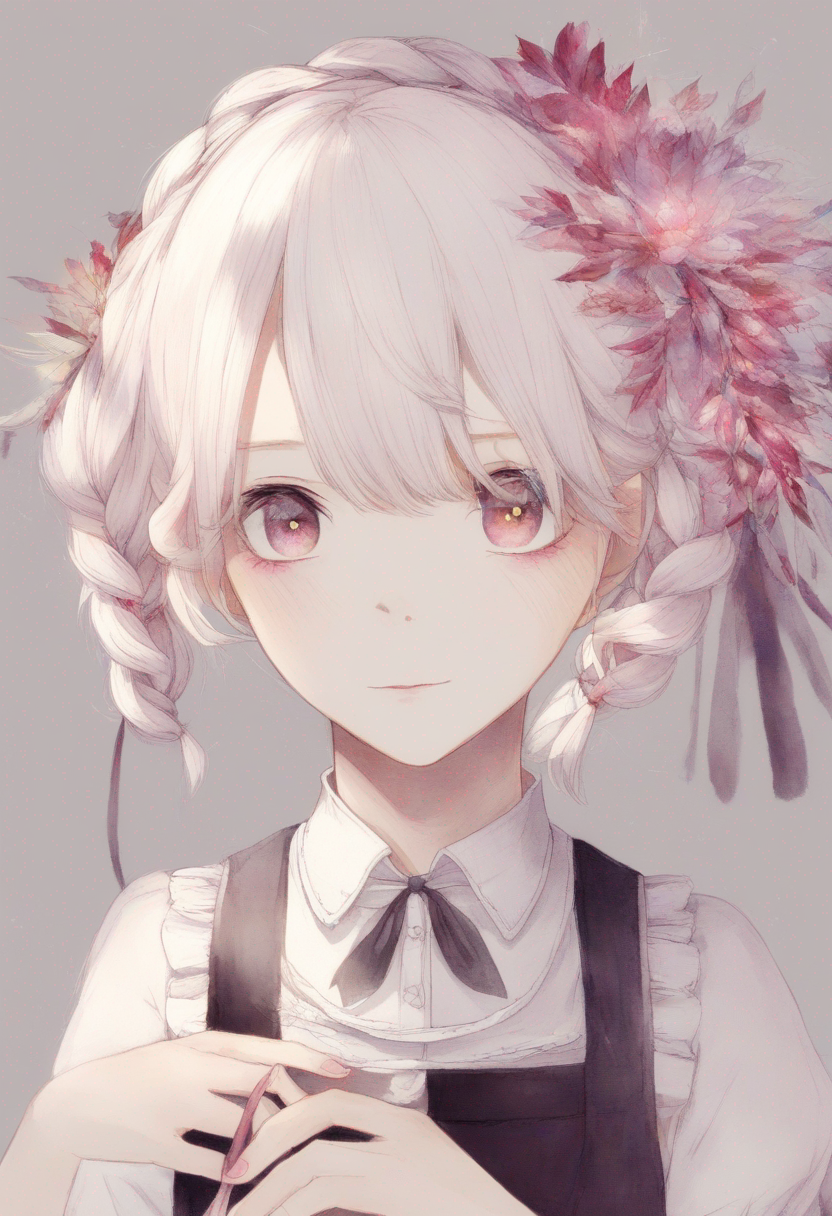


Seeds for generating images: [132937459929060, 3863522634787884]


In [37]:
# run prediction
response = predictor.predict(data={
    "prompt": "1girl, solo, looking_at_viewer, short_hair, bangs, simple_background, hair_ornament, white_background, hair_between_eyes, closed_mouth, upper_body, braid, flower, white_hair, frills, parted_lips, hair_flower, pink_eyes, apron, twin_braids, from_side, looking_to_the_side, maid, maid_headdress, profile, rose, sideways_glance, black_flower",
    "negative_prompt": "ugly, disfigured, deformed",
    "height": 1216,
    "width": 832,
    "num_images_per_prompt": 2,
    "refiner": "enable",
    "high_noise_frac": 0.8,
    # "seed" : 3904759173130859  # uncomment seed and replace with generated one, if you want to produce same
  }
)

print(f"\nNotification: {response['notification']}\n")

# decode images
decoded_images = [decode_base64_image(image) for image in response["generated_images"]]

# visualize generation
i = 0
for image in decoded_images:
    display(image)
    seed = response['seeds'][i]
    i = i+1
    
# print(seeds)
print(f"\nSeeds for generating images: {response['seeds']}")